#Project 2- Recommender Systems

In [ ]:
#!pip install pandas
#!pip install numpy
!pip install regex
!pip install nltk
!pip install sklearn
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import nltk
import multiprocessing
import umap.umap_ as umap
import umap.plot
import re
import string
import warnings
from tabulate import tabulate
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import mean_squared_error as MSE
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_classification, fetch_20newsgroups
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.optimize import linear_sum_assignment
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from joblib import Memory
from tempfile import mkdtemp
from string import punctuation
from nltk import pos_tag, word_tokenize, sent_tokenize
from nltk.corpus import wordnet
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import joblib
np.random.seed(0)
random.seed(0)

In [ ]:
#Importing Drive
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/Shareddrives/ECE219/Project 3'

Mounted at /content/drive
/content/drive/Shareddrives/ECE219/Project 3


In [ ]:
Dataset_Rep = 'Dataset_Movie_Lens/'

In [ ]:
#Ratings_file.head()
Dataset_loc = 'Dataset_Movie_Lens/'
Dataset = pd.read_csv(Dataset_loc+"ratings.csv") 
Dataset.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [ ]:
Dataset.describe()

,Unnamed: 0,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,50417.500000,326.127564,19435.295718,3.501562,1.205946e+09
std,29108.990209,182.618491,35530.987199,1.042540,2.162610e+08
min,0.000000,1.000000,1.000000,0.500000,8.281246e+08
25%,25208.750000,177.000000,1199.000000,3.000000,1.019124e+09
50%,50417.500000,325.000000,2991.000000,3.500000,1.186087e+09
75%,75626.250000,477.000000,8122.000000,4.000000,1.435994e+09
max,100835.000000,610.000000,193609.000000,5.000000,1.537799e+09


#Question 1

Explore the Dataset: In this question, we explore the structure of the data.

Compute the sparsity of the movie rating dataset:
Sparsity =
Total number of available ratings
Total number of possible ratings

In [ ]:
Ratings_file = pd.read_csv(Dataset_Rep+"ratings.csv",usecols=['userId','movieId','rating','timestamp']) 
user_ID = Ratings_file.pop('userId').values
movie_ID = Ratings_file.pop('movieId').values
Rating = Ratings_file.pop('rating').values
Sparsity = len(Rating)/(len(set(movie_ID))*len(set(user_ID)))
print('Sparsity:',Sparsity)

Sparsity: 0.016999683055613623


Plot a histogram showing the frequency of the rating values: Bin the raw rating values
into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the
number of entries in the ratings matrix R that fall within each bin and use this count as the
height of the vertical axis for that particular bin. Comment on the shape of the histogram.

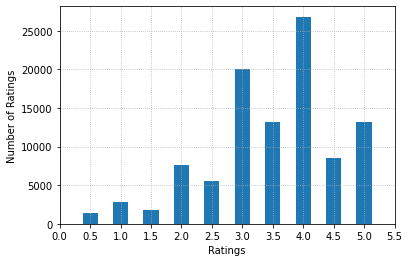

In [ ]:
uni_values, uni_indices = np.unique(Rating, return_inverse=True)
plt.bar(uni_values, np.bincount(uni_indices), width=0.25)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(0,6,0.5),rotation=0)
plt.ylabel('Number of Ratings')
plt.xlabel('Ratings')
plt.savefig('Q2_1.png',dpi=500,bbox_inches='tight')
plt.show()

Plot the distribution of the number of ratings received among movies: The X-axis
should be the movie index ordered by decreasing frequency and the Y -axis should be the number
of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend
is expected.

[329 317 307 ...   1   1   1]


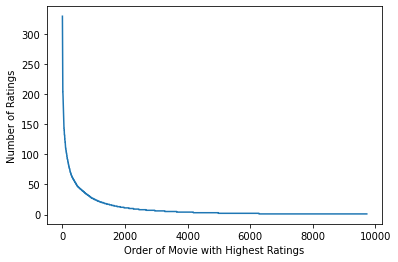

In [ ]:
#Movie ID vs number of ratings
unique_movie,unique_counts=np.unique(movie_ID,return_counts=True)
count_sorts=np.argsort(unique_counts)
length=range(1,len(unique_movie)+1)
count=unique_counts[count_sorts[::-1]] #Decreasing Frequency
print(count)
plt.plot(length,count)
plt.xlabel('Order of Movie with Highest Ratings')
plt.ylabel('Number of Ratings')
plt.show()


Plot the distribution of ratings among users: The X-axis should be the user index ordered
by decreasing frequency and the Y -axis should be the number of movies the user has rated.
The requirement of the plot is similar to that in Question C.


[2698 2478 2108 1864 1346 1302 1260 1218 1115 1055 1046 1027  977  975
  943  939  904  879  862  836  831  763  728  728  722  703  677  648
  646  635  613  608  600  578  575  570  528  520  518  517  507  505
  502  500  476  474  469  467  465  458  455  446  443  443  440  437
  437  436  411  403  403  400  399  398  397  386  385  383  377  371
  366  363  360  359  347  345  340  334  331  314  311  310  306  300
  299  294  293  292  291  289  279  279  277  275  273  271  270  269
  267  267  265  260  258  255  250  248  247  242  237  236  233  232
  232  231  230  227  226  226  223  221  217  216  216  215  213  210
  210  208  207  204  202  202  201  200  196  194  191  190  189  188
  187  187  186  185  181  180  179  177  176  174  173  168  168  168
  167  167  167  165  165  164  164  163  161  157  156  155  155  155
  154  152  152  152  152  150  150  150  148  141  141  141  141  140
  140  140  140  139  138  138  138  135  135  135  134  133  131  131
  130 

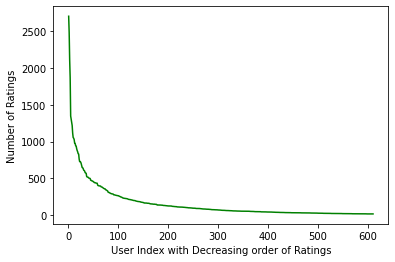

In [ ]:
#User ID vs Number of movies the user has rated
unique_movie1,unique_counts1=np.unique(user_ID,return_counts=True)
count_sorts=np.argsort(unique_counts1)
length1=range(1,len(unique_movie1)+1)
count1=unique_counts1[count_sorts[::-1]] #Decreasing Frequency
print(count1)
plt.plot(length1,count1,color='g')
plt.xlabel('User Index with Decreasing order of Ratings')
plt.ylabel('Number of Ratings')
plt.show()


Discuss the salient features of the distributions from Questions C,D and their implications
for the recommendation process.

Compute the variance of the rating values received by each movie: Bin the variance
values into intervals of width 0.5 and use the binned variance values as the horizontal axis.
Count the number of movies with variance values in the binned intervals and use this count as
the vertical axis. Briefly comment on the shape of the resulting histogram

In [ ]:
movie_set=set(movie_ID)
movie_set=list(movie_set) #can't subscript set
list_movies=[]
list_variance=[]
for movie_ele in range(len(movie_set)):
  #For each  unique movie ID, find all it's indexes from the movie ID corpus to access corresponding ratings
  pos=[ind for ind,ele in enumerate(movie_ID) if ele==movie_set[movie_ele] ]
  #list of all corresponding rattings values to find variance of a single unique movie ID's ratings
  variance=np.var(np.array(Rating[pos]))
  list_variance.append(variance)
  list_movies.append(movie_set[movie_ele])

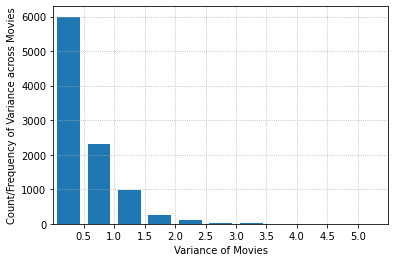

In [ ]:
#Plotting histogram
plt.hist(list_variance, bins=np.arange(0,5.5,0.5),rwidth=0.75)
plt.xticks(np.arange(0.5,5.5,0.5))
plt.xlim([0, 5.5])
plt.grid(linestyle=':')
plt.xlabel('Variance of Movies')
plt.ylabel('Count/Frequency of Variance across Movies')
plt.show()

#Question 2

Understanding the Pearson Correlation Coefficient:


In [ ]:
print(max(Rating),min(Rating))
#Ratings dynamic range is from 0.5 to 5


5.0 0.5


#Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the
original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of
neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average
MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis)
against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [ ]:
!pip install scikit-surprise
from surprise import Reader, Dataset
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split


#Get lineformat corresponding tags CSV file in dataset  - Documentation - https://surprise.readthedocs.io/en/stable/reader.html
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_Rep+'ratings.csv',reader=CSV_reader)
for data in Dataset_Ratings.raw_ratings[:2]:
  print(data)
print(Dataset_Ratings.raw_ratings[:10])

k=[i for i in  range(2,103,2)]
list_RMSE=[]
lisst_mae=[]
# for ele in k:
#   knn=KNNWithMeans(k=ele,sim_options={'name':'pearson'})
#   final_res=cross_validate(knn,measures=['rmse','mae'],data=Dataset_Ratings,cv=10)
#   list_RMSE.append(np.mean(final_res['test_rmse']))
#   lisst_mae.append(np.mean(final_res['test_mae']))

     |████████████████████████████████| 11.8 MB 30.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623336 sha256=7f498dcd542aba66613d1b433df6f8b0800fe320d1d9e3fafb59f43451e65288
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
('0', '496', 112852.0, '3.0')
('1', '391', 1947.0, '4.0')
[('0', '496', 112852.0, '3.0'), ('1', '391', 1947.0, '4.0'), ('2', '387', 1562.0, '1.5'), ('3', '474', 2716.0, '4.5'), ('4', '483', 88125.0, '4.5'), ('5', '375', 344.0, '4.0'), ('6', '438', 4388.0, '2.5'), ('7', '534', 98491.0, '4.0'), ('8', '288', 2719.0, '2.0'), ('9', '288', 1287.0, '4.0')]
